## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [27]:
# IPython Interactive Widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

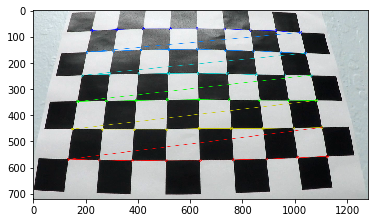

In [28]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
shape = None

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    shape = gray.shape[::-1]

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        
# Calibrating camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)

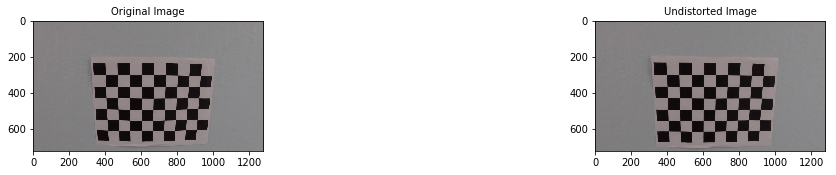

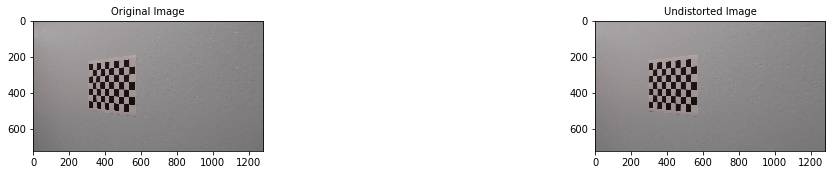

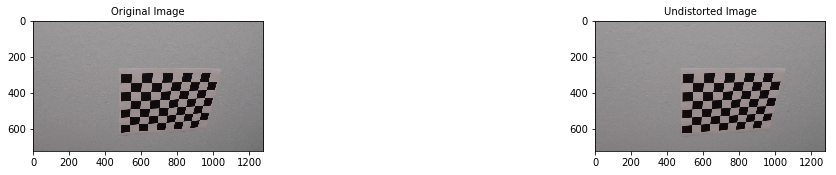

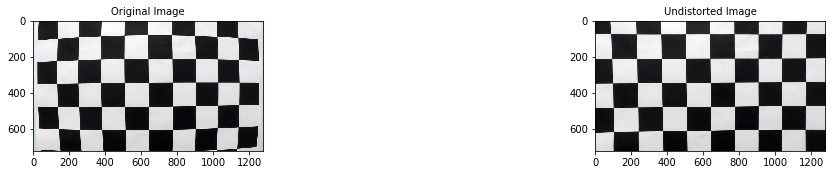

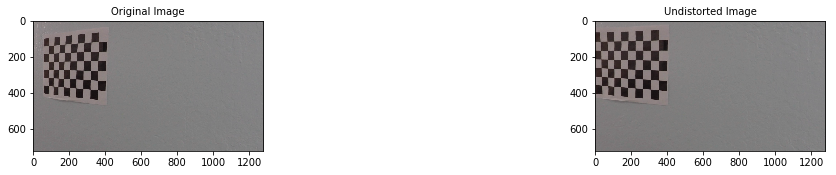

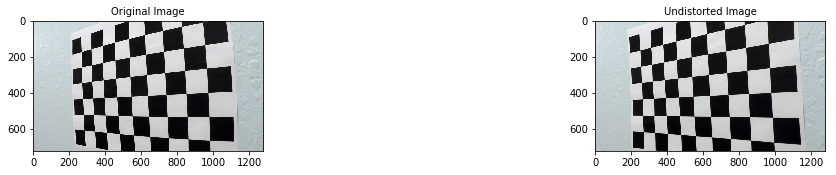

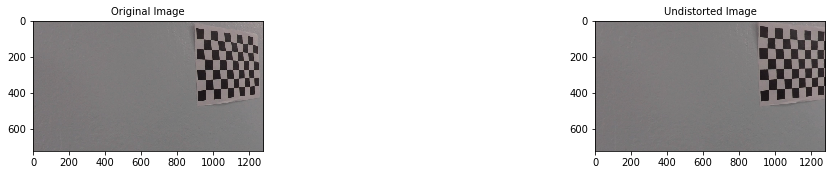

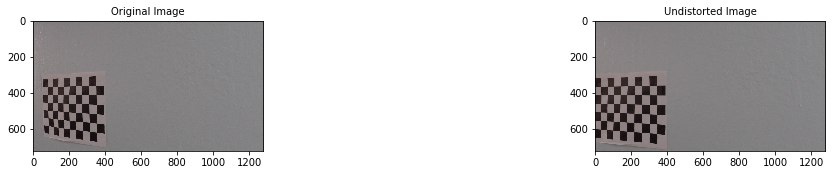

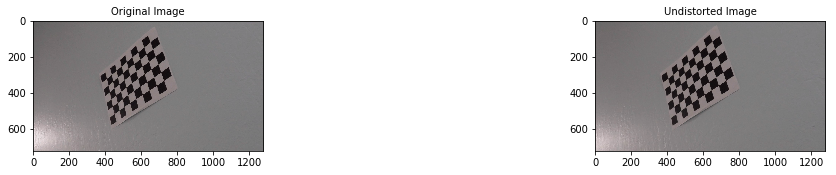

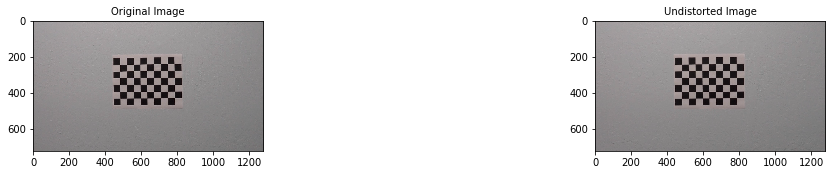

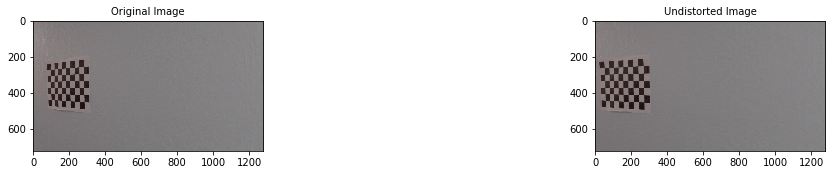

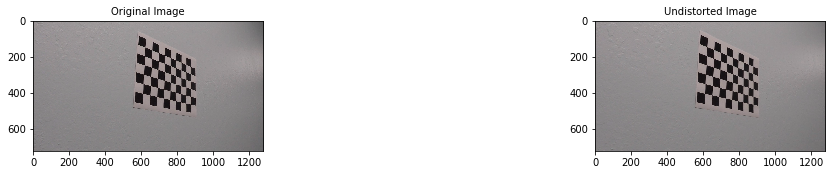

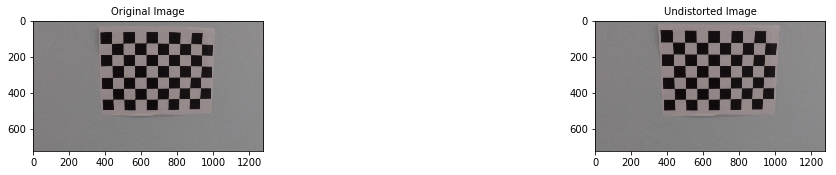

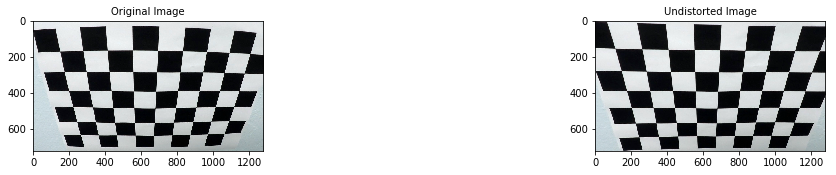

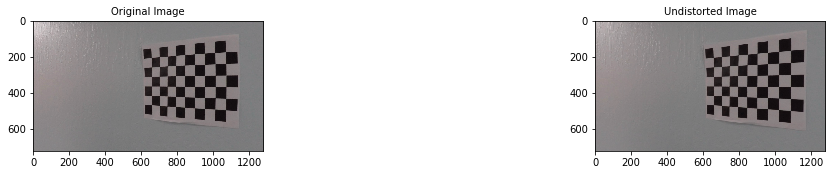

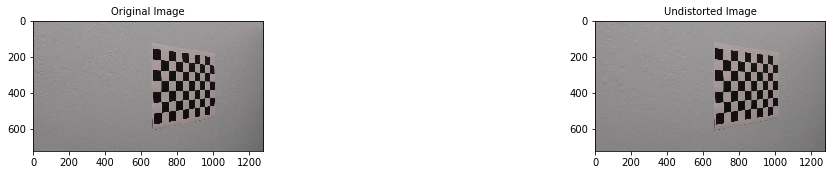

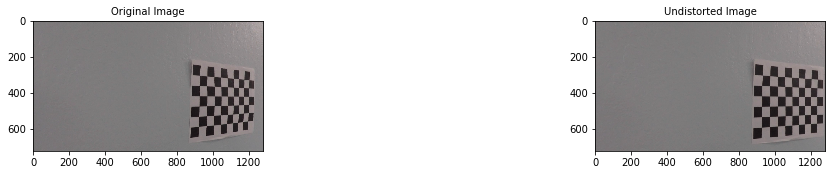

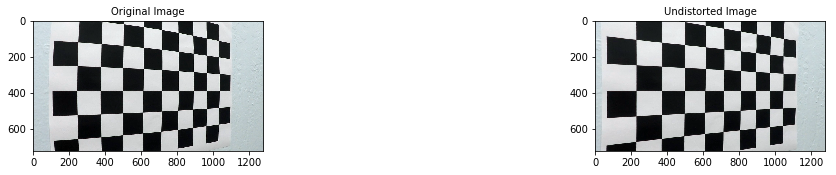

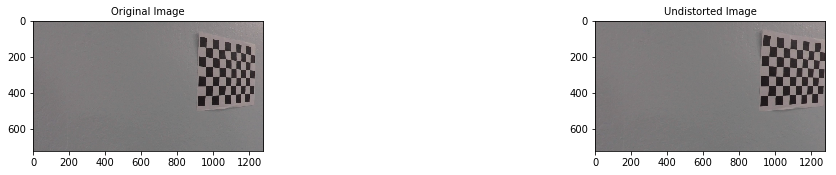

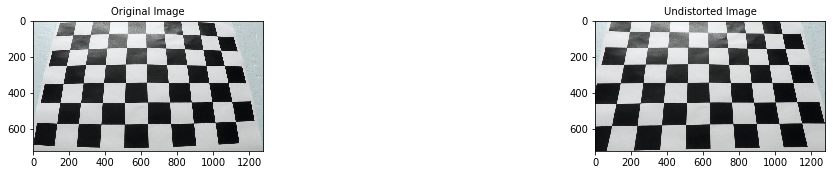

In [34]:
images = glob.glob('./camera_cal/calibration*.jpg')
shape = None

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.imshow(undist)

## And so on and so forth...

In [9]:
def f(x):
    return x

In [10]:
interact(f, x=10);

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-interact',))

In [11]:
interact(f, x='Hi there!');

interactive(children=(Text(value='Hi there!', description='x'), Output()), _dom_classes=('widget-interact',))

In [12]:
@interact(x=True, y=1.0)
def g(x, y):
    return (x, y)

interactive(children=(Checkbox(value=True, description='x'), FloatSlider(value=1.0, description='y', max=3.0, min=-1.0), Output()), _dom_classes=('widget-interact',))

In [14]:
def h(p, q):
    return (p, q)
interact(h, p=5, q=fixed(20));

interactive(children=(IntSlider(value=5, description='p', max=15, min=-5), Output()), _dom_classes=('widget-interact',))